In [1]:
using CairoMakie, Base64, Printf, LaTeXStrings, BenchmarkTools, Statistics;  #default(fmt=:png)
using NCDatasets, AvailablePotentialEnergyFramework
using JLD

In [2]:
plots_dir = "/global/u2/a/aramreye/RamirezReyes_MECFeedbackInTCWorld/plotsandanimations/"
data_dir = "/global/cscratch1/sd/aramreye/for_postprocessing/largencfiles/"

"/global/cscratch1/sd/aramreye/for_postprocessing/largencfiles/"

In [3]:
nudging_time_list = ["5e-1h", "1h", "2h", "3h", "5h", "8h", "5e-1day", "1day", "2day", "5day", "10day",  "15day"]
experiment_labels = "τ = " .* ["½h", "1h", "2h", "3h", "5h", "8h", "12h", "1d", "2d","5d", "10d",  "15d"];
file_list = string.("f5e-4_2km_1000km_homoRad_homoSfc_nudgeClearsky_",nudging_time_list,"_2d.nc")
push!(file_list,"f5e-4_2km_1000km_homoRad_homoSfc_2d.nc")
push!(experiment_labels,"No Nudging")

13-element Vector{String}:
 "τ = ½h"
 "τ = 1h"
 "τ = 2h"
 "τ = 3h"
 "τ = 5h"
 "τ = 8h"
 "τ = 12h"
 "τ = 1d"
 "τ = 2d"
 "τ = 5d"
 "τ = 10d"
 "τ = 15d"
 "No Nudging"

In [4]:
function read_data(filename,times)
    Dataset(filename) do ds
        psfc =variable(ds,"PSFC")[:,:,times] :: Array{Float32,3}
        u = variable(ds,"USFC")[:,:,times] :: Array{Float32,3}
        v = variable(ds,"VSFC")[:,:,times] :: Array{Float32,3}
        time = variable(ds,"time")[times] :: Array{Float32,1}
        pw =variable(ds,"PW")[:,:,times] :: Array{Float32,3}
        sp = hypot.(u,v)
        #psfc = permutedims(psfc,(2,1,3))
        #sp = permutedims(sp,(2,1,3))
        psfc, sp, time, pw
    end
end

read_data (generic function with 1 method)

In [5]:
indices_to_plot = [1,2,4,9,12,13]
time_slab = 1:5:2400
data = [read_data(joinpath(data_dir,file), time_slab) for file in file_list[indices_to_plot]];

In [6]:
time_idx = Observable(1)
psfc = [@lift(onedata[1][:,:,$time_idx]) for onedata in data]
sp = [@lift(onedata[2][:,:,$time_idx]) for onedata in data]
pw = [@lift(onedata[4][:,:,$time_idx]) for onedata in data]
time_string = @lift(@sprintf "Pressure and wind speed at the surface and water vapor at day %5.1f" data[1][3][$time_idx])


Observable{String} with 0 listeners. Value:
"Pressure and wind speed at the surface and water vapor at day   0.0"

In [7]:
x = y = range(0, stop = 1024, length= 512)

0.0:2.003913894324853:1024.0

In [8]:
size(data[5][1])

(512, 512, 480)

In [9]:
length(data)

6

In [10]:
timeindices = 1:480

1:480

In [11]:
letters = string.('a':'z');

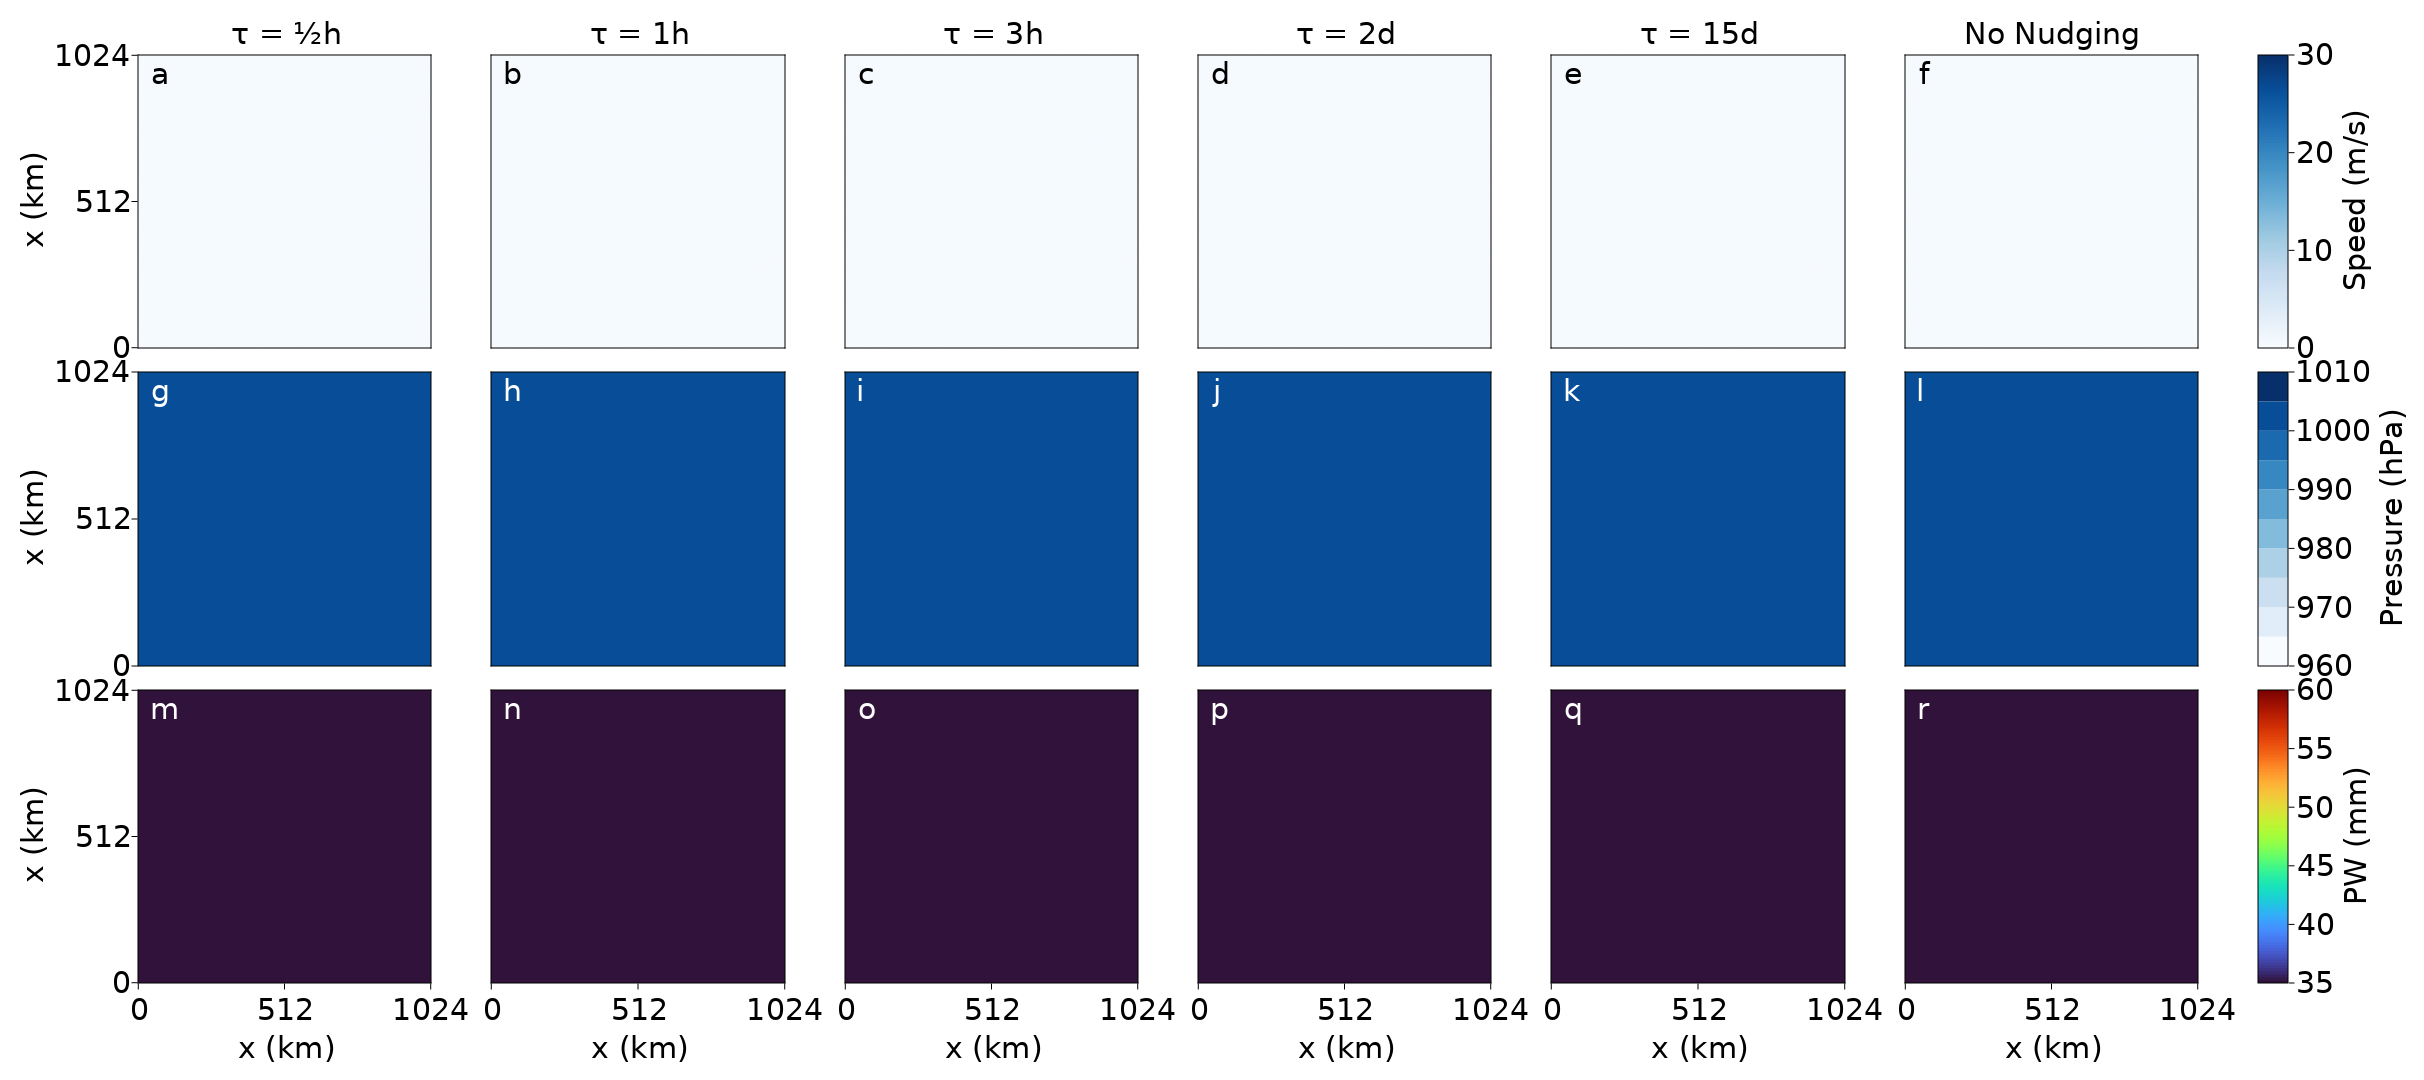

In [12]:
set_theme!(fontsize = 30, colgap = 60,Axis = (
        xticks = [0,512,1024],
        yticks = [0,512,1024]))

fig = Figure(resolution = (1920,1080))
axes_list1 = []
axes_list2 = []
axes_list3 = []
heatmaps_list = []
contours_list = []
contours_list3 = []
for (col, exp) in enumerate(sp)
    newax = Axis(fig[fldmod1(col,6)...], title = experiment_labels[indices_to_plot[col]], 
        titlesize=30, xlabel = "x (km)", ylabel = "x (km)",aspect = AxisAspect(1))
    hm = heatmap!(newax,x,y,exp, colorrange = (0,30), colormap = :Blues)
    text!(newax, position = (50,900),string(letters[col]), textsize = 30)
    push!(axes_list1,newax), push!(heatmaps_list,hm)
end

for (col, exp) in enumerate(psfc)
    newax = Axis(fig[1 + fld1(col,6), mod1(col,6)], 
        xlabel = "x (km)", ylabel = "x (km)",aspect = AxisAspect(1))
    hm = contourf!(newax,x,y,exp, colormap = :Blues, levels = 960:5:1010)
    text!(newax, position = (50,900),string(letters[col + 6]), textsize = 30, color=:white)
    push!(axes_list2,newax), push!(contours_list,hm)
end

for (col, exp) in enumerate(pw)
    newax = Axis(fig[2 + fld1(col,6), mod1(col,6)], 
        xlabel = "x (km)", ylabel = "x (km)",aspect = AxisAspect(1))
    hm = heatmap!(newax,x,y,exp, colormap = :turbo, colorrange = (35,60))
    text!(newax, position = (50,900),string(letters[col + 12]), textsize = 30, color=:white)
    push!(axes_list3,newax), push!(contours_list3,hm)
end
hideydecorations!.(axes_list1[2:end])
hideydecorations!.(axes_list2[2:end])
hideydecorations!.(axes_list3[2:end])
hidexdecorations!.(axes_list1)
hidexdecorations!.(axes_list2)

Colorbar(fig[1,7],heatmaps_list[1],label = "Speed (m/s)", width = 30, tellheight=false)
Colorbar(fig[2,7],contours_list[1],label = "Pressure (hPa)", width = 30, tellheight=false)
Colorbar(fig[3,7],contours_list3[1],label = "PW (mm)", width = 30, tellheight=false)
#supertitle = fig[0, :] = Label(fig, "Surface wind speed and pressure at day $(ceil(Int,snapshots_sp[1][2]))",
#    textsize = 40)
tightlimits!.(axes_list2)
[colsize!(fig.layout, col, Aspect(1, 1.0)) for col in 1:6]
resize_to_layout!(fig)
fig

In [ ]:
record(fig, joinpath(plots_dir,"time_animation_nudging.mp4"), timeindices; framerate = 10, compression = 1) do t
    time_idx[] = t 
end